## Automation

A few lessons learned Earth Analytics 2018

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import earthpy.spatial as es

## Using Multiple .append() Calls Takes Time!

`.append()` creates a new object - EVERY TIME it is called  


```python
# Create empty lists to hold values
ndvi_final = []
month_values = []
site_name_list = []

# Collect month, mean ndvi & site, add to list
month_values.append(band[-32:-30])
ndvi_temp_values.append(ndvi_mean_temp)
site_name_list.append(subdirs)

ndvi_final.append(ndvi_temp_values)
# Unpack the nested ndvi_temp_values list
ndvi = [value for temp_value in ndvi_final for value in temp_value]
```

## What Approach is Fastest?

try it! 

In [7]:
%%timeit
val1 = list()
val2 = list()
val3 = list()

val1.append([1])
val2.append([15])
val3.append(["SJER"])
# 1 microsecond = 1,000 nano seconds = ~1,036 ns

843 ns ± 19.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [8]:
%%timeit
all_data = list()

ndvi = 1
day = 15
site = "SJER"
all_data.append([ndvi, day, site])

324 ns ± 24.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [9]:
# Cell to generate objects as timeit runs in it's own namespace
all_data = list()

ndvi = 1
day = 15
site = "SJER"
all_data.append([ndvi, day, site])

In [10]:
# Once you have a list of all values, you can neatly create a pandas dataframe
pd.DataFrame(all_data,
             columns=["ndvi", "day", "site"])

,ndvi,day,site
0,1,15,SJER


## Avoid Manually Created Loop Counters

In [11]:
all_sites = ["site1", "site2", "site3"]
# Initialize loop counter
loop_count = 0

for site in all_sites:
    loop_count = loop_count + 1
    print(loop_count)

1
2
3


## Instead Of a Counter, Use Enumerate

The result: cleaner code.


In [12]:
# Use enumerate
all_sites = ["site1", "site2", "site3"]

for counter, site in enumerate(all_sites):
    print(counter, site)

0 site1
1 site2
2 site3


## Always Sort Lists from Glob

Why, you might ask?

![](ndvi-plot.png)

<img src="scooby.png" style="width:500px;height:500px;"> 

In [17]:
# What if you have two file paths that are not in the right order?
file_paths = [os.path.join("data", "file", "stuff_band_5.tif"),
              os.path.join("data", "file", "stuff_band_4.tif")]
file_paths

['data/file/stuff_band_5.tif', 'data/file/stuff_band_4.tif']

In [18]:
# Sort the data
file_paths.sort()
file_paths

['data/file/stuff_band_4.tif', 'data/file/stuff_band_5.tif']

![](ndvi-plot.png)

## Add Checks to Your Code

How do you know you are calculating NDVI on the correct bands?

In [19]:
# OPTION : test to ensure you are grabbing the right band
for file in file_paths:
    if "band_4" in file:
        band4 = "i'm band 4"
    elif "band_5" in file:
        band5 = "i'm band 5"
    else:  # Make sure there are the correct bands for NDVI calculation are in the given folder
        raise ValueError(
            "Oops, I can't find the right bands. Thanks for playing.")

band4, band5

("i'm band 4", "i'm band 5")

In [21]:
# OPTION 2: use dictionaries with keys
my_dict = {}
for file in file_paths:
    # Get band name from file given all files are uniformly named
    the_band = file[16:22]
    # Open the band and store a raster in the dictionary
    my_dict[the_band] = np.random.randint(10, size=(4, 5))

# Note you'd prob want to test to ensure two bands exist here or above to calculate ndvi!
ndvi = es.normalized_diff(b1=my_dict["band_4"], b2=my_dict["band_5"])
ndvi.data

array([[-0.5       ,  0.25      , -0.27272727,  1.        ,  1.        ],
       [-0.77777778, -1.        ,  0.5       , -0.2       ,  0.23076923],
       [-0.28571429,  0.5       , -0.71428571,  0.07692308,  0.        ],
       [-0.5       ,  0.14285714,  0.5       ,  0.6       , -0.33333333]])

## But still, how do you know you're using the right bands?

In [22]:
# OPTION 2: use dictionaries with keys!
my_dict = {}
for file in file_paths:
    the_band = file[16:22]
    my_dict[the_band] = 5

# Do both bands exist? if they do calculate NDVI, otherwise fail gracefully
try:
    ndvi = my_dict["band_5"] - my_dict["band_4"]
except AssertionError:
    raise AssertionError("""Please make sure that you have a band 4 and 
                         band 5 for for this landsat scene""")

my_dict, ndvi

({'band_4': 5, 'band_5': 5}, 0)

In [3]:
# OPTION 2: use dictionaries with keys!
file_paths_2 = [os.path.join("data", "file", "stuff_band_6.tif"),
              os.path.join("data", "file", "stuff_band_4.tif")]
my_dict = {}
for file in file_paths_2:
    the_band = file[16:22]
    my_dict[the_band] = 5

# DO both bands exist? if they do calculate NDVI, otherwise fail gracefully
try:
    ndvi = my_dict["band_5"] - my_dict["band_4"]
except AssertionError:
    raise AssertionError("""Opps, can't calculate NDVI. You need band 4 and 
                         band 5 for for this calculation""")

KeyError: 'band_5'

## Parallel Processing - Map is Fast 

Map uses all CPUs available to iterate (parallel processing). 
Map requires you to:

1. write a function
2. iterate on that function across a list of items

```python
output_map = map(summarize_scene, all_scene_dirs)
```

If you write your code so your function call to process all scenes is OUTSIDE of a loop. This means that you'd want a function that was like (with a shorter funct name of course)

`calculate_ndvi_for_a_single_site()`

You can then do this

```
for asite in all_sites:
   calculate_ndvi_for_a_single_site(asite)
```

or this:
`[calculate_ndvi_for_a_single_site(asite) for asite in all_sides]`

OR use map (fastest)


`list(map(calculate_ndvi_for_a_single_site, all_sites))`

In [4]:
items = [1, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5]


def sqr(x):
    return x ** 2

In [14]:
%%timeit
my_list = list()
for item in items:
    my_list.append(sqr(item))

my_list

9.14 µs ± 150 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [15]:
%%timeit
list(map(sqr, items))

7.28 µs ± 33.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [13]:
%%timeit
[sqr(item) for item in items]

8.45 µs ± 281 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Plotting Groups in Pandas

In [50]:
# Create some pretend data for 2 sites
all_ndvi_vals = [["SJER", .3, "2018-03-01"],
                 ["SJER", .5, "2018-05-01"],
                 ["SJER", .7, "2018-07-01"],
                 ["SJER", .6, "2018-09-01"],
                 ["HARV", .09, "2018-03-01"],
                 ["HARV", .08, "2018-05-01"],
                 ["HARV", .09, "2018-07-01"],
                 ["HARV", 1, "2018-09-01"]]

all_ndvi_df = pd.DataFrame(all_ndvi_vals,
                           columns=["site", "ndvi", "date"])
all_ndvi_df['date'] = pd.to_datetime(all_ndvi_df['date'])

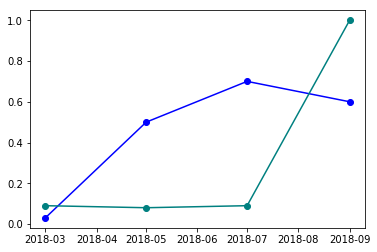

In [52]:
# One option - plot each set of data individually
SJER_landsat_means = all_ndvi_df[all_ndvi_df.site == "SJER"]
HARV_landsat_means = all_ndvi_df[all_ndvi_df.site == "HARV"]

# Plot data
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.plot(SJER_landsat_means['date'],
         SJER_landsat_means['ndvi'],
         c='blue', marker="o", label='SJER')
ax1.plot(HARV_landsat_means['date'],
         HARV_landsat_means['ndvi'],
         c='teal', marker="o", label='HARV')
plt.show()

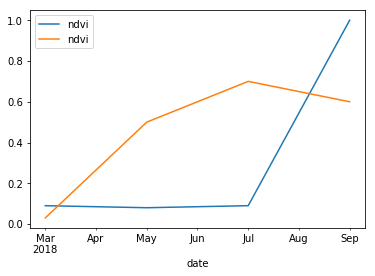

In [78]:
fig, ax = plt.subplots(figsize=(6, 4))
all_ndvi_df.groupby(by="site").plot(x="date",
                                    y="ndvi",
                                    ax=ax)
plt.show()

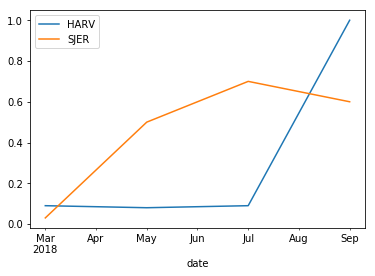

In [80]:
# Create a loop to customize legend
fig, ax = plt.subplots(figsize=(6, 4))

for name, group in all_ndvi_df.groupby(by="site"):
    group.plot(x="date", 
               y="ndvi", 
               ax=ax, 
               label=name)

## Follow Pep8 Guidelines
Use double quotes for strings.

In [ ]:
# Use """ triple quotes instead of """ -  '''single quotes''' for all text strings
def process_and_stack_site(site_path, remove_clouds=False):
    '''
    This function does stuff...
    '''
    
    # do something
    return #something
    